In this notebook you will find:

Me training both a XGBClassifier and a CatBoostClassifier with the set of features (both cont. and cat.) that were highly correlated with the target.

Both yielded similar results in terms of what variables they deemed "important", i.e. high SHAP-values but also in their performance (AURC).

But XGBoost executed way faster (3x) so I chose to test adding/removing features always on XGBoost going forward.

The broad result of those tests:

-walk-balance-and-gait-impairment is the strongest variable along with age and fall-risk_+ (a good indication as to why that is can be found by looking at crosstabs or at the heatmaps furhter down in this notebook)

-those three variables are highly correlated (also visible by the stacked bar-plots further down in this notebook); that means that removing any of them only reduces performance (AUPR) by a small  or can even increase it!

-removing any of the other features that have small SHAP-values can sometimes lead to rather grave reductions in performance which indicates for me that there is some "hidden effect" between the variables that isnt captured by SHAP

You will also find here the evaluation pipeline I built which is very similar to the one with the simple decision trees.
Dont get confused by the small recall-values you can somtimes get when testing on the test-set; that is because of the default threshold of 0.5. This recall can be enhanced by lowering this threshold. The relevant metric here is really the AUPR

The next thing I will do is automate this feture selection since the exact effact is very hard to tell manually. You kind of have to go through every permutation.

Doing it automatically though can kind of lead you the wrong way and takes long...


In [1]:
import pandas as pd
# %pip install autoviz
#from autoviz.AutoViz_Class import AutoViz_Class
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
import numpy as np
import scipy.stats as stats
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.tree import plot_tree
from sklearn.tree import export_text
from sklearn.feature_selection import RFE
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score, recall_score
from sklearn.metrics import (
    accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, roc_curve
)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_predict
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    precision_recall_curve, roc_auc_score, confusion_matrix, classification_report, auc
)
from catboost import CatBoostClassifier, Pool
import xgboost as xgb
import shap
from scipy.integrate import trapezoid

c:\Users\felix\OneDrive\Dokumente\FU_Working\ApplAna\FallPredictionUV\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
pd.set_option('display.max_rows', 100)

In [3]:
pwd()

'c:\\Users\\felix\\OneDrive\\Dokumente\\FU_Working\\ApplAna\\FallPredictionUV\\repos\\Applied-Analytics-Portfolio'

In [4]:
path = "C:\\Users\\felix\\OneDrive\\Dokumente\\FU_Working\\ApplAna\\FallPredictionUV\\kip_sdm_syn.csv"
df = pd.read_csv(path, sep=",")

In [5]:
# Split into train (80%) and test (20%)
df, test_df = train_test_split(df, test_size=0.1, stratify=df["fallen"], random_state=42)

## Dataset Creation One-Hot Encoding

In [6]:
df["transfer"].value_counts()

transfer
2     2016
3      436
4A     166
1       86
4B      10
Name: count, dtype: int64

In [7]:
df['transfer'] = df['transfer'].fillna('Unknown')
df = pd.get_dummies(df, columns=['transfer'])


In [8]:
df["bed_mobility-jones"].value_counts()

bed_mobility-jones
2     1501
3      445
4A     129
1       79
4B       5
Name: count, dtype: int64

In [9]:
df['bed_mobility-jones'] = df['bed_mobility-jones'].fillna('Unknown')
df = pd.get_dummies(df, columns=['bed_mobility-jones'])

In [10]:
df['walk-jones'] = df['walk-jones'].fillna('Unknown')
df = pd.get_dummies(df, columns=['walk-jones'])

In [11]:
df['decubitus-risk'] = df['decubitus-risk'].fillna('Unknown')
df = pd.get_dummies(df, columns=['decubitus-risk'])

In [12]:
df['fall-risk'] = df['fall-risk'].fillna('Unknown')
df = pd.get_dummies(df, columns=['fall-risk'])

### Always Execute

In [13]:
df['procedure'] = df['procedure'].fillna('Unknown')
df = pd.get_dummies(df, columns=['procedure'])

In [14]:
df['diagnosis'] = df['diagnosis'].fillna('Unknown')
df = pd.get_dummies(df, columns=['diagnosis'])

In [15]:
df['sex'] = df['sex'].fillna('Unknown')
df = pd.get_dummies(df, columns=['sex'])

In [16]:
df["decubitus-admission"] = df["decubitus-admission"].astype("boolean")
df["decubitus-at_the_moment"] = df["decubitus-at_the_moment"].astype("boolean")
df["bed_mobility-impairment"] = df["bed_mobility-impairment"].astype("boolean")
df["bed_mobility-skin_condition"] = df["bed_mobility-skin_condition"].astype("boolean")
df["transfer-impairment"] = df["transfer-impairment"].astype("boolean")
df["medical_items"] = df["medical_items"].astype("boolean")
df["medical_items-skin_condition_at_item_application"] = df["medical_items-skin_condition_at_item_application"].astype("boolean")
df["fall-last_12_month"] = df["fall-last_12_month"].astype("boolean")
df["fall-while_stay"] = df["fall-while_stay"].astype("boolean")
df["fall-while_transfer"] = df["fall-while_transfer"].astype("boolean")
df["walk-impairment"] = df["walk-impairment"].astype("boolean")
df["excretions-impairment"] = df["excretions-impairment"].astype("boolean")
df["cognition-impairment"] = df["cognition-impairment"].astype("boolean")
df["psychotropic_or_sedatives_drugs"] = df["psychotropic_or_sedatives_drugs"].astype("boolean")
df["diseases"] = df["diseases"].astype("boolean")

### Additional encodings to fix NaNs

In [17]:
df["fall-how_many_last_12_month_missing"] = df["fall-how_many_last_12_month"].isna()

In [18]:
df['fall-while_stay'] = df['fall-while_stay'].astype('object').fillna('Unknown')
df = pd.get_dummies(df, columns=['fall-while_stay'])

In [19]:
df['transfer-impairment'] = df['transfer-impairment'].astype('object').fillna('Unknown')
df = pd.get_dummies(df, columns=['transfer-impairment'])

In [20]:
df['bed_mobility-impairment'] = df['bed_mobility-impairment'].astype('object').fillna('Unknown')
df = pd.get_dummies(df, columns=['bed_mobility-impairment'])

In [21]:
df['excretions-impairment'] = df['excretions-impairment'].astype('object').fillna('Unknown')
df = pd.get_dummies(df, columns=['excretions-impairment'])

In [22]:
df['cognition-impairment'] = df['cognition-impairment'].astype('object').fillna('Unknown')
df = pd.get_dummies(df, columns=['cognition-impairment'])

In [30]:
df['walk-impairment'] = df['walk-impairment'].astype('object').fillna('Unknown')
df = pd.get_dummies(df, columns=['walk-impairment'])

In [31]:
df['fall-while_transfer'] = df['fall-while_transfer'].astype('object').fillna('Unknown')
df = pd.get_dummies(df, columns=['fall-while_transfer'])

In [32]:
df['fall-last_12_month'] = df['fall-last_12_month'].astype('object').fillna('Unknown')
df = pd.get_dummies(df, columns=['fall-last_12_month'])

In [33]:
df['medical_items-skin_condition_at_item_application'] = df['medical_items-skin_condition_at_item_application'].astype('object').fillna('Unknown')
df = pd.get_dummies(df, columns=['medical_items-skin_condition_at_item_application'])

In [34]:
df['medical_items'] = df['medical_items'].astype('object').fillna('Unknown')
df = pd.get_dummies(df, columns=['medical_items'])

In [35]:
df['bed_mobility-skin_condition'] = df['bed_mobility-skin_condition'].astype('object').fillna('Unknown')
df = pd.get_dummies(df, columns=['bed_mobility-skin_condition'])

In [36]:
df['decubitus-at_the_moment'] = df['decubitus-at_the_moment'].astype('object').fillna('Unknown')
df = pd.get_dummies(df, columns=['decubitus-at_the_moment'])

In [38]:
df['decubitus-admission'] = df['decubitus-admission'].astype('object').fillna('Unknown')
df = pd.get_dummies(df, columns=['decubitus-admission'])

In [47]:
df['psychotropic_or_sedatives_drugs'] = df['psychotropic_or_sedatives_drugs'].astype('object').fillna('Unknown')
df = pd.get_dummies(df, columns=['psychotropic_or_sedatives_drugs'])

In [46]:
df['diseases'] = df['diseases'].astype('object').fillna('Unknown')
df = pd.get_dummies(df, columns=['diseases'])

In [39]:
df.head()

,fallen,id,age,c_zriserh1,medical_items-arm_or_leg_splint,medical_items-A_V_system,medical_items-plaster_or_neck_brace,medical_items-compression_stocking,medical_items-ventilation_mask,medical_items-O2_glasses,...,medical_items_True,medical_items_Unknown,bed_mobility-skin_condition_False,bed_mobility-skin_condition_True,bed_mobility-skin_condition_Unknown,decubitus-at_the_moment_False,decubitus-at_the_moment_True,decubitus-at_the_moment_Unknown,decubitus-admission_False,decubitus-admission_Unknown
6690,False,77363,49,False,False,False,False,False,False,False,...,False,True,False,False,True,True,False,False,False,True
35722,False,80749,34,True,False,False,False,False,False,False,...,False,True,False,False,True,False,False,True,False,True
32809,False,23355,39,False,False,False,False,False,False,False,...,False,True,False,False,True,True,False,False,False,True
10660,False,36660,29,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,True,False,True
33450,False,15012,54,False,False,False,False,False,False,False,...,False,False,False,False,True,True,False,False,False,True


In [23]:
median_value = df["fall-how_many_last_12_month"].median()
df["fall-how_many_last_12_month"] = df["fall-how_many_last_12_month"].fillna(median_value)

In [48]:
na_percentage = df.isna().mean().to_string()
print(na_percentage)

fallen                                                      0.0
id                                                          0.0
age                                                         0.0
c_zriserh1                                                  0.0
medical_items-arm_or_leg_splint                             0.0
medical_items-A_V_system                                    0.0
medical_items-plaster_or_neck_brace                         0.0
medical_items-compression_stocking                          0.0
medical_items-ventilation_mask                              0.0
medical_items-O2_glasses                                    0.0
medical_items-orthesis                                      0.0
medical_items-prosthesis                                    0.0
fall-how_many_last_12_month                                 0.0
walk-balance_and_gait_impaired                              0.0
walking_aid                                                 0.0
excretions-incontinence                 

In [42]:
df["diseases"].value_counts()

diseases
False    8551
True      510
Name: count, dtype: Int64

In [120]:
train_columns = ["id", "age", "excretions-impairment_True", "excretions-impairment_False", "fall-risk_+", "walk-balance_and_gait_impaired", "fall-how_many_last_12_month", "excretions-incontinence", "fall-while_stay_True", "fall-while_stay_Unknown", "transfer-impairment_Unknown", "transfer-impairment_True", "bed_mobility-impairment_False", "bed_mobility-impairment_True", "fall-how_many_last_12_month_missing", "fallen"] 
df1 = df[train_columns]

removing fall12months missing reduces by 0.02

same for fallhowmany12months

Even though they have little SHAP

Removing cognition-imapirment dummmies alongside fall-risk reduces AURC very little

Dropping age increases AURC?!

Dropping walk-balance-and-gait decreases AURC.

The three most important features age,walkbalance and fall_risk_+ seems to be correlated since dropping either of them has a harsh effect on AURC.


Best parameters found:
{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Best cross-validation recall: 0.0440
(array([0, 1]), array([7199,    1], dtype=int64))

Test set performance with optimized hyperparameters:
Recall: 0.0000
              precision    recall  f1-score   support

       False       1.00      1.00      1.00      7183
        True       0.00      0.00      0.00        17

    accuracy                           1.00      7200
   macro avg       0.50      0.50      0.50      7200
weighted avg       1.00      1.00      1.00      7200

AUC-PR Score: 0.2226
ROC-AUC Score: 0.9915


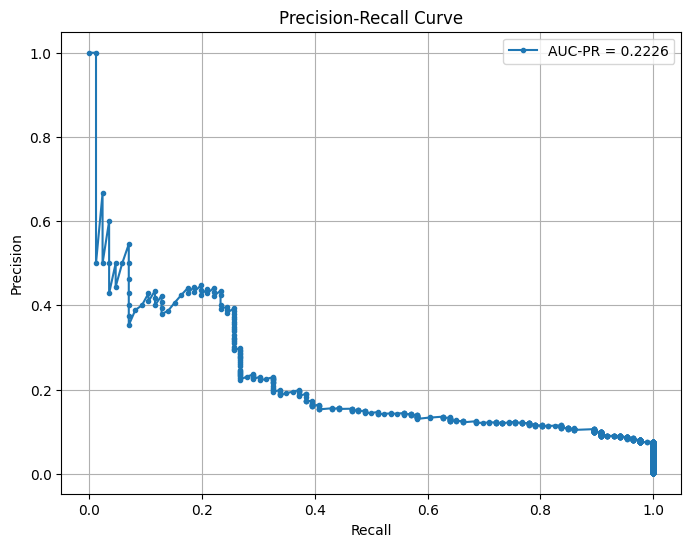

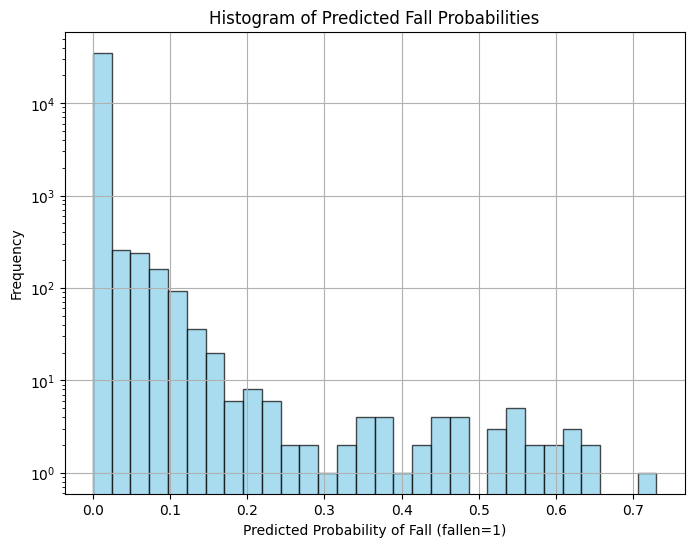

Best Threshold for Precision-Recall Balance: 0.2319


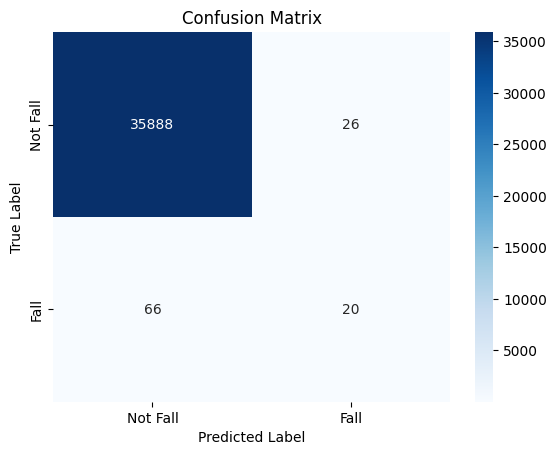

Top 10 Important Features:
                                Feature  Importance
4        walk-balance_and_gait_impaired    0.727055
6               excretions-incontinence    0.060474
3                           fall-risk_+    0.057752
7                  fall-while_stay_True    0.035590
8               fall-while_stay_Unknown    0.023780
11        bed_mobility-impairment_False    0.014073
1            excretions-impairment_True    0.013506
10             transfer-impairment_True    0.013211
2           excretions-impairment_False    0.012700
12         bed_mobility-impairment_True    0.011008
13  fall-how_many_last_12_month_missing    0.008991
5           fall-how_many_last_12_month    0.008259
0                                   age    0.007108
9           transfer-impairment_Unknown    0.006492
Shap Values for the train set


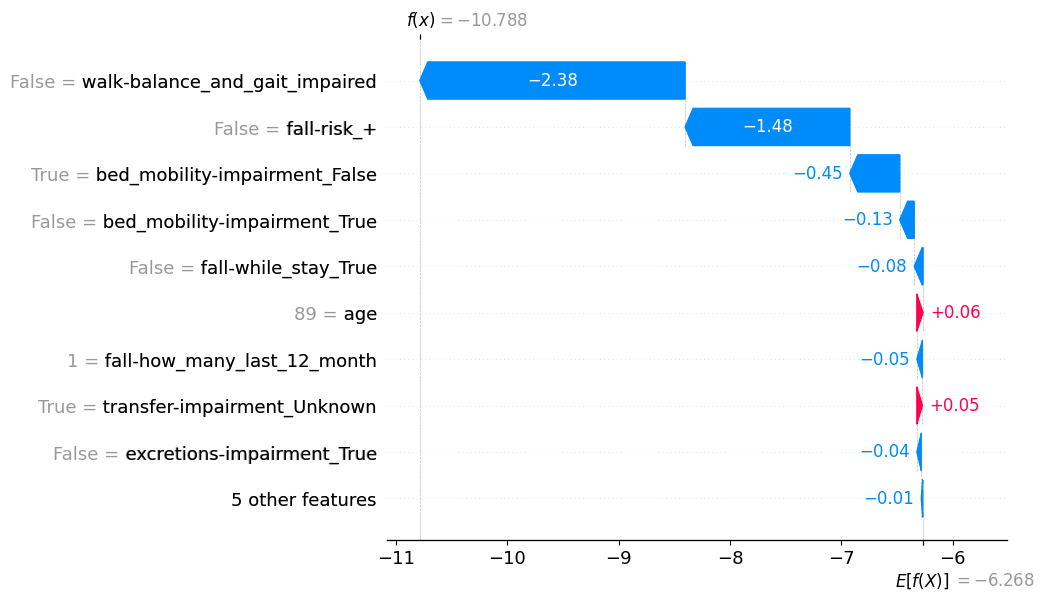

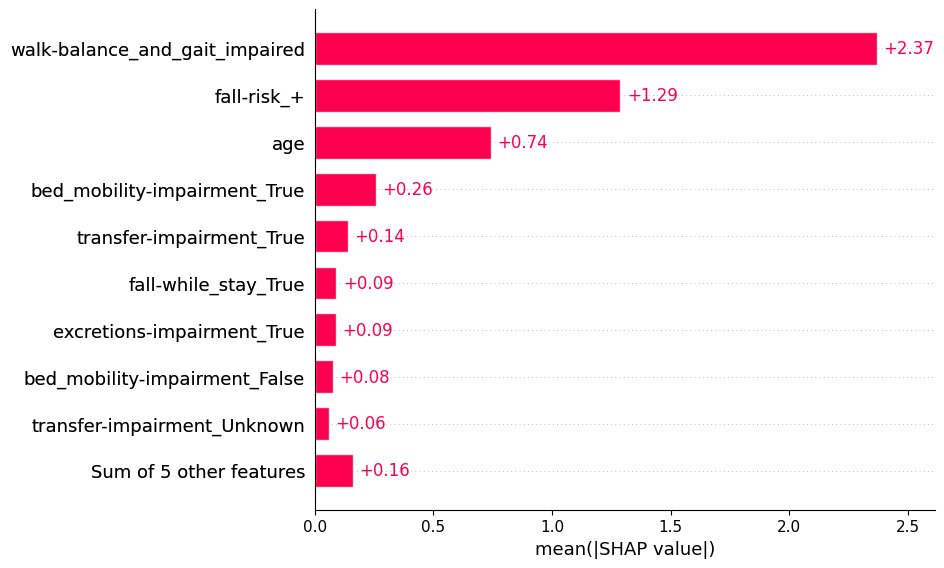

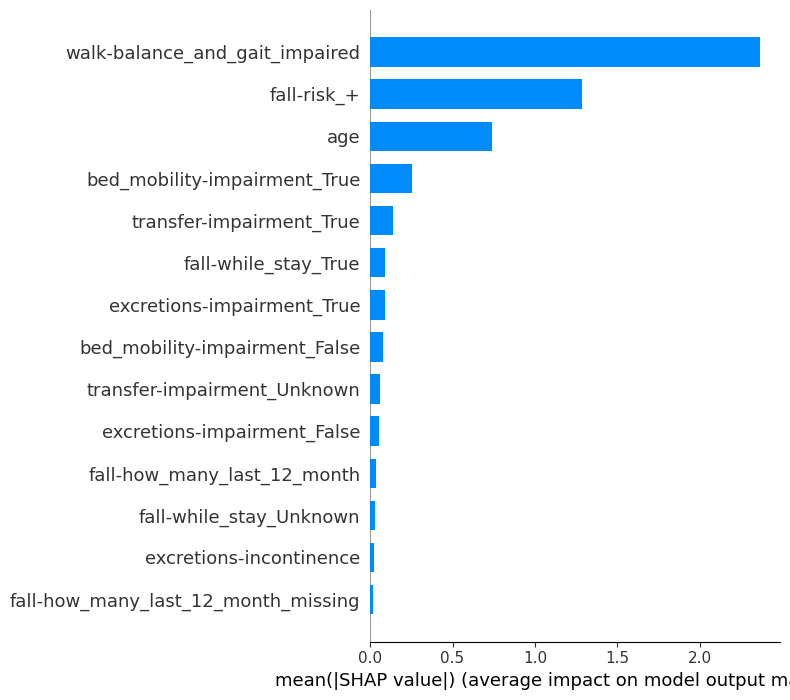

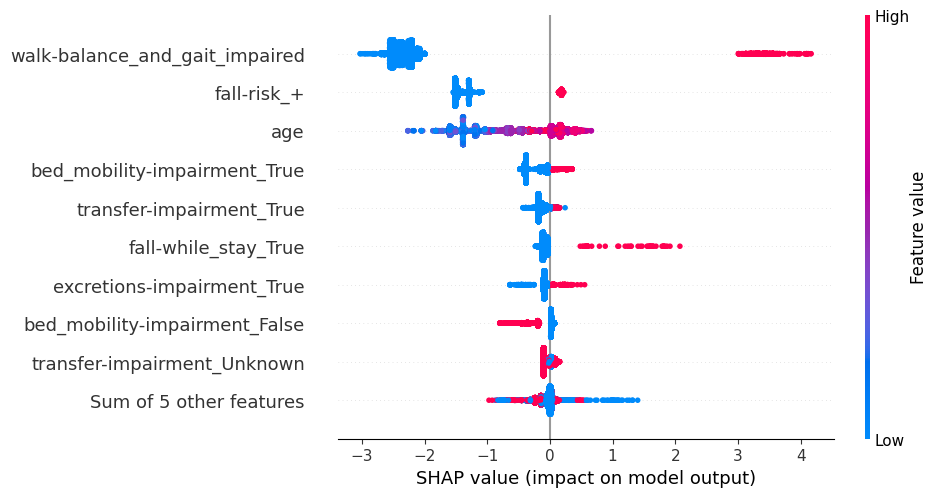

Shap Values for the test set


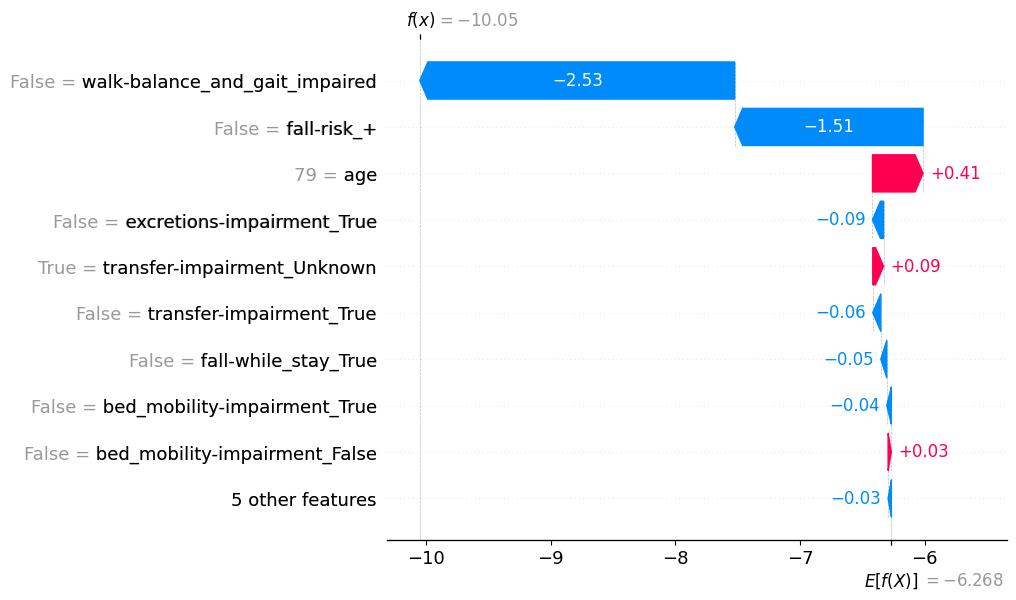

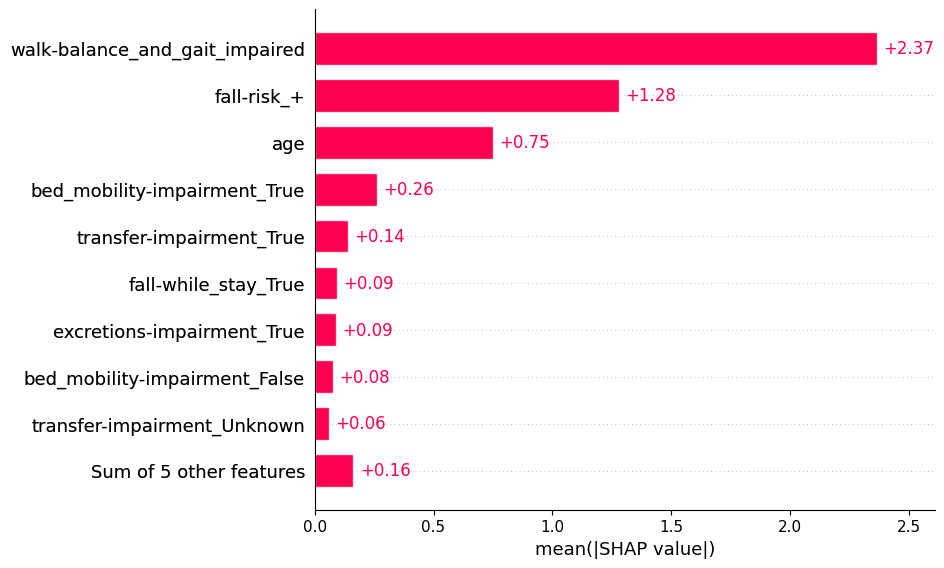

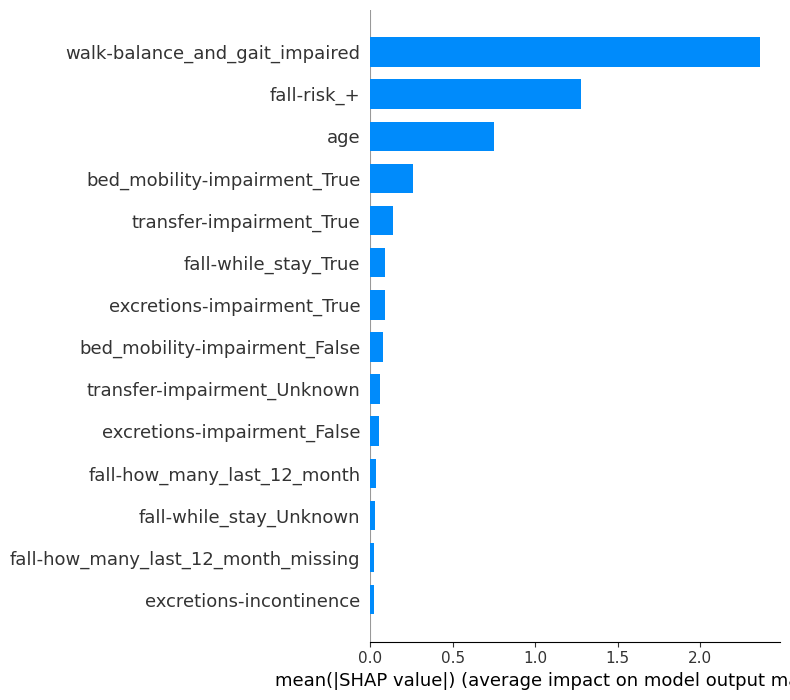

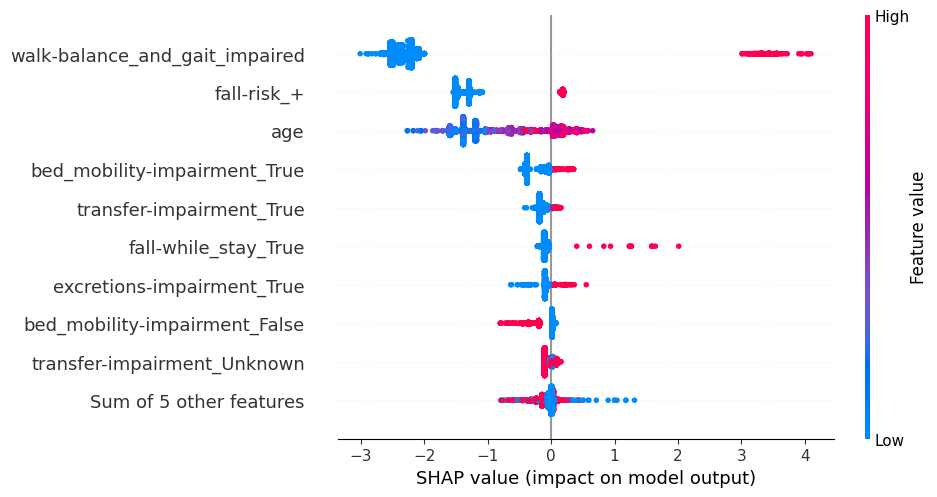

In [121]:
xgb_pipeline(df1)

## XGBoost Model

In [95]:

def xgb_pipeline(df):
    """
    Trains and evaluates a Decision Tree model with hyperparameter tuning, 
    finds the best threshold for recall/precision, and visualizes performance.

    Args:
        df (pd.DataFrame): The cleaned dataset.
        target_col (str): Target variable name.
        test_size (float): Train-test split ratio.
        random_state (int): Random seed for reproducibility.

    Returns:
        dict: Model performance metrics.
    """

    
    # === Load Data ===
    X = df.drop(columns=["fallen", "id"])  # Features
    y = df["fallen"]  # Target  

    # Split train/test sets
    # Use stratified sampling to ensure balanced class distribution
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )


    # === Step 1: Define Model & Parameter Grid ===
    model = xgb.XGBClassifier()

    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [3, 6],
        'learning_rate': [0.01, 0.1]
    }

    # === Step 2: Hyperparameter Tuning using GridSearchCV ===
    grid_search = GridSearchCV(model, param_grid, scoring="recall", cv=5, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Best model after tuning
    best_classifier = grid_search.best_estimator_

    # Print the best parameters and best score
    print("\nBest parameters found:")
    print(grid_search.best_params_)
    print(f"Best cross-validation recall: {grid_search.best_score_:.4f}")



    # Train a model with the best parameters
    best_classifier.fit(X_train, y_train)

    # Evaluate on test set
    y_pred_best_classifier = best_classifier.predict(X_test)
    print(np.unique(y_pred_best_classifier, return_counts=True))

    print("\nTest set performance with optimized hyperparameters:")
    print(f"Recall: {recall_score(y_test, y_pred_best_classifier):.4f}")
    print(classification_report(y_test, y_pred_best_classifier))


    # === Step 3: Cross-Validation Prediction for Evaluation ===
    cv = StratifiedKFold(n_splits=5)
    y_probs = cross_val_predict(best_classifier, X, y, cv=cv, method="predict_proba")[:, 1]

    

    # === Step 4: Compute AUC-PR ===
    precision, recall, thresholds = precision_recall_curve(y, y_probs)
    auc_pr = auc(recall, precision)
    roc_auc = roc_auc_score(y, y_probs)

    print(f"AUC-PR Score: {auc_pr:.4f}")
    print(f"ROC-AUC Score: {roc_auc:.4f}")

    # === Step 5: Plot Precision-Recall Curve ===
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, marker=".", label=f"AUC-PR = {auc_pr:.4f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend()
    plt.grid()
    plt.show()

    # === Step 6: Histogram of Prediction Probabilities ===
    plt.figure(figsize=(8, 6))
    plt.hist(y_probs, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
    plt.title("Histogram of Predicted Fall Probabilities")
    plt.xlabel("Predicted Probability of Fall (fallen=1)")
    plt.ylabel("Frequency")

    # Apply logarithmic scale to y-axis
    plt.yscale('log')
    plt.grid(True)
    plt.show()

    # === Step 7: Find Best Threshold for Recall-Precision Tradeoff ===
    best_threshold = thresholds[np.argmax(precision * recall)]
    print(f"Best Threshold for Precision-Recall Balance: {best_threshold:.4f}")

    # Apply the best threshold
    y_pred = (y_probs >= best_threshold).astype(int)

    # === Step 8: Confusion Matrix ===
    cm = confusion_matrix(y, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Fall", "Fall"], yticklabels=["Not Fall", "Fall"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

    # === Step 9: Feature Importance ===
    feature_importances = pd.DataFrame(
        {"Feature": X.columns, "Importance": best_classifier.feature_importances_}
    ).sort_values(by="Importance", ascending=False)

    print("Top 10 Important Features:")
    print(feature_importances.head(30))

    print("Shap Values for the train set")
    explainer = shap.TreeExplainer(best_classifier)
    shap_values_train = explainer(X_train)

    shap.plots.waterfall(shap_values_train[0])

    shap.plots.bar(shap_values_train)
    shap.summary_plot(shap_values_train, X_train, plot_type="bar")

    shap.plots.beeswarm(shap_values_train)

    print("Shap Values for the test set")
    shap_values_test = explainer(X_test)
    shap.plots.waterfall(shap_values_test[0])

    shap.plots.bar(shap_values_test)
    shap.summary_plot(shap_values_test, X_test, plot_type="bar")

    shap.plots.beeswarm(shap_values_test)

    # print("Summary of One-Hot Variables")
    # shap_df = pd.DataFrame(shap_values_test.values, columns=X_test.columns)
    # shap.summary_plot(shap_values_test, X_test, plot_type="bar")

    # # Group SHAP values by original categorical feature
    # category_columns = ["fall-risk_0", "fall-risk_+", "fall-risk_++"]
    # # Aggregate SHAP values for the original feature
    # shap_df["fall-risk_SHAP"] = shap_df[category_columns].sum(axis=1)

    # plt.figure(figsize=(6, 4))
    # sns.boxplot(y=shap_df["fall-risk_SHAP"])
    # plt.ylabel("SHAP Value")
    # plt.title("Distribution of Aggregated SHAP Values for Fall Risk")
    # plt.show()
            


Best parameters found:
{'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100}
Best cross-validation recall: 0.1154
(array([0, 1]), array([7191,    9], dtype=int64))

Test set performance with optimized hyperparameters:
Recall: 0.2353
              precision    recall  f1-score   support

       False       1.00      1.00      1.00      7183
        True       0.44      0.24      0.31        17

    accuracy                           1.00      7200
   macro avg       0.72      0.62      0.65      7200
weighted avg       1.00      1.00      1.00      7200

AUC-PR Score: 0.2058
ROC-AUC Score: 0.9906


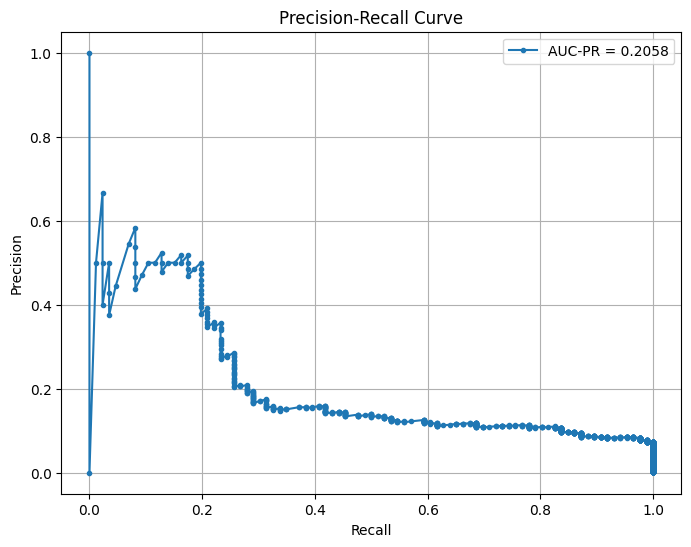

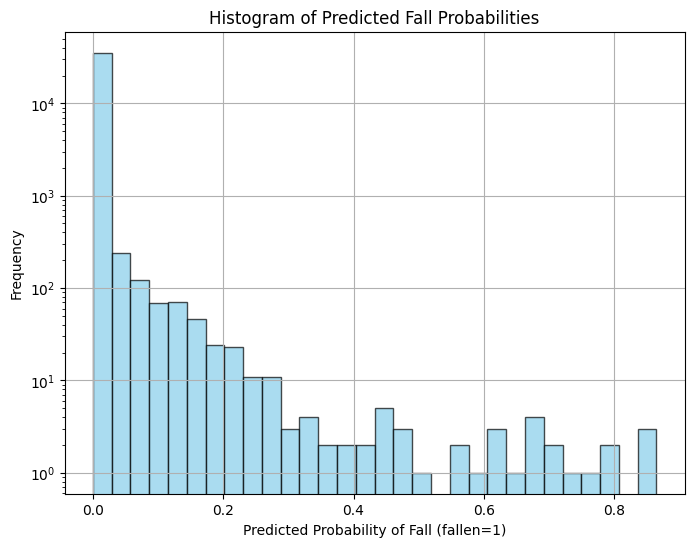

Best Threshold for Precision-Recall Balance: 0.3647


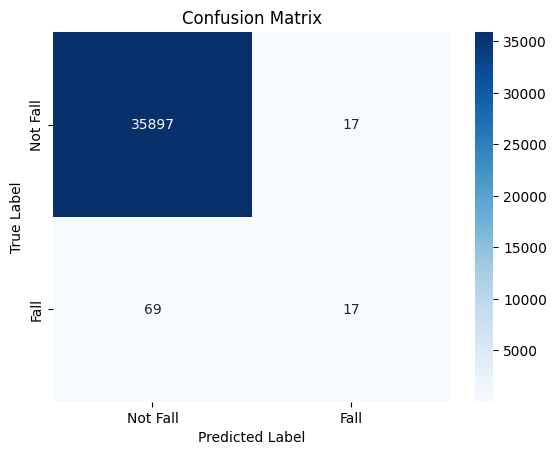

Top 10 Important Features:
                           Feature  Importance
6   walk-balance_and_gait_impaired    0.827039
5                      fall-risk_+    0.064405
8             fall-while_stay_True    0.027628
7          excretions-incontinence    0.012750
11        transfer-impairment_True    0.009198
12   bed_mobility-impairment_False    0.008649
2      excretions-impairment_False    0.008628
9          fall-while_stay_Unknown    0.008353
13    bed_mobility-impairment_True    0.006844
10     transfer-impairment_Unknown    0.006766
3       cognition-impairment_False    0.006068
0                              age    0.005324
4        cognition-impairment_True    0.004340
1       excretions-impairment_True    0.004008
Shap Values for the train set


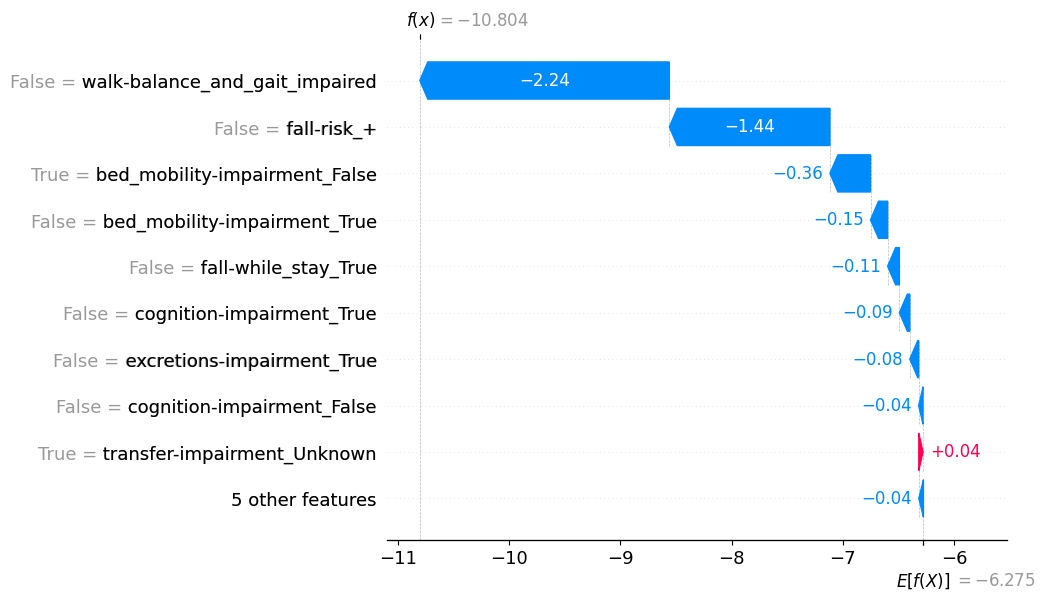

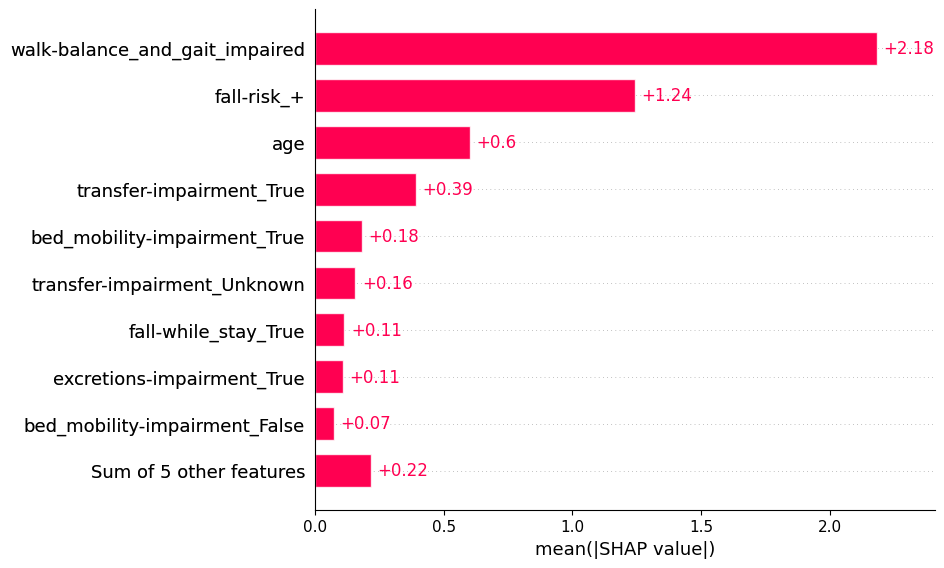

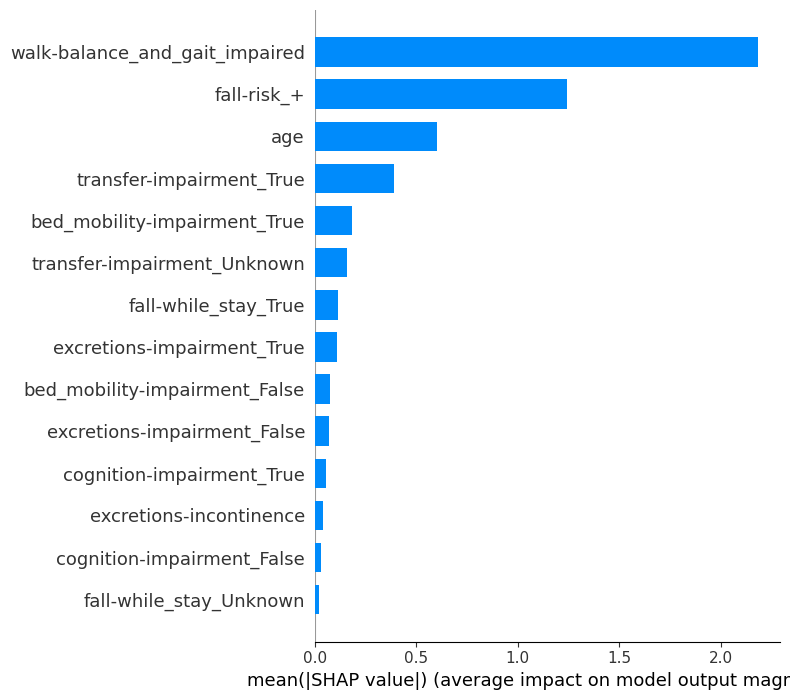

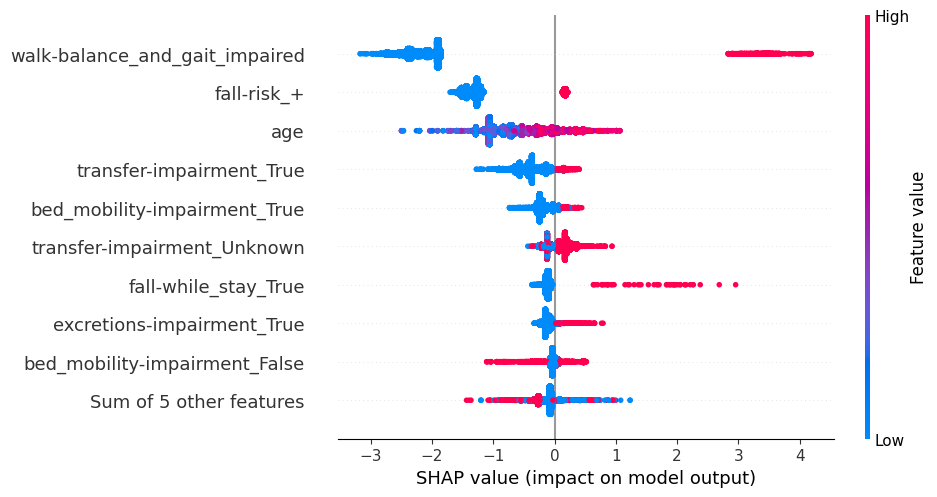

Shap Values for the test set


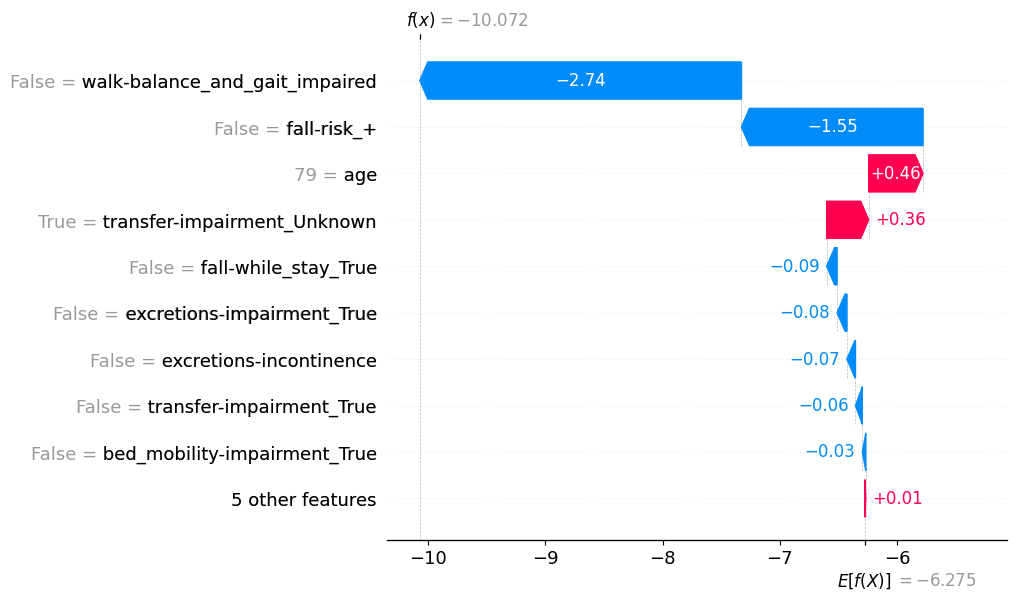

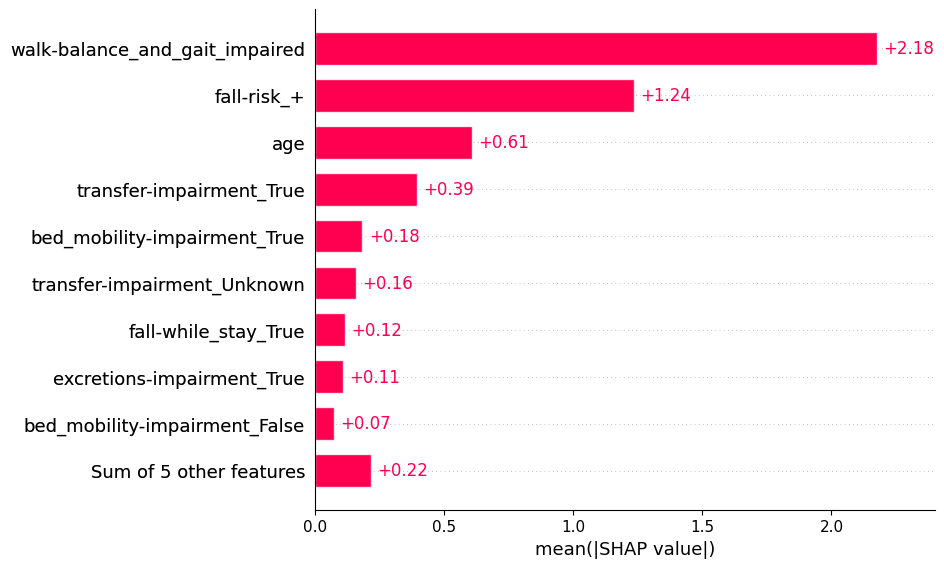

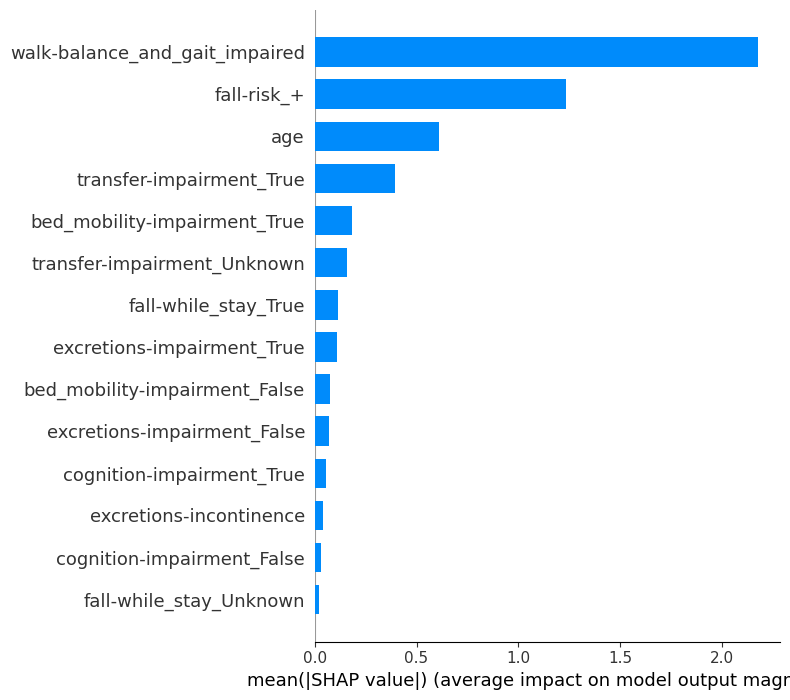

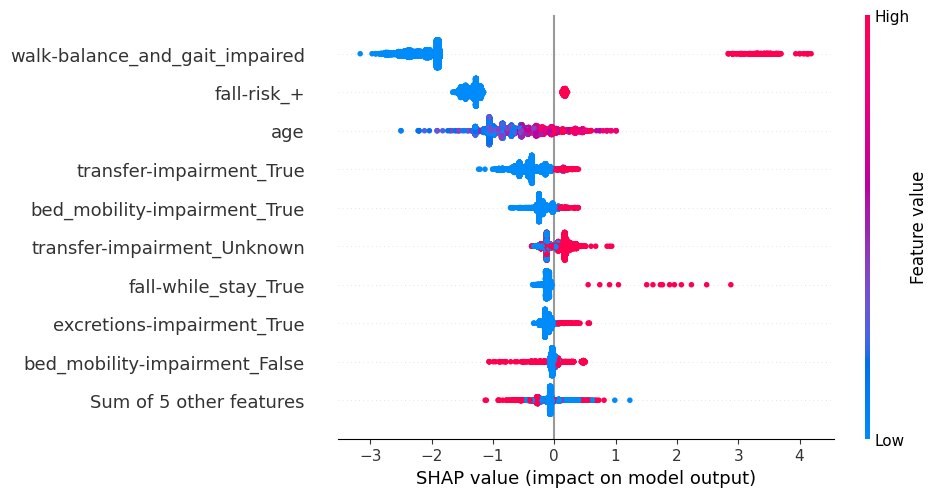

In [103]:
xgb_pipeline(df1)

In [99]:
df["walk-balance_and_gait_impaired"].value_counts()

walk-balance_and_gait_impaired
False    34737
True      1263
Name: count, dtype: int64

## Experiments

In contrast to the decision tree, adding the excretions impairment and cognition impairmnet dummies increases the AURC here. Even though they add very little.

fall-riks_++ and fall_risk_0 add nothing. After removal model performance does not decrease but explainability increases due to fewer variables.

fall-howmanylast12 months and fall how many last 12 months also add very little.

## Visualizations to explina effects

C:\Users\felix\AppData\Local\Temp\ipykernel_2296\97186582.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_counts = df_viz.groupby('age_group')['fall-risk_+'].value_counts().unstack()


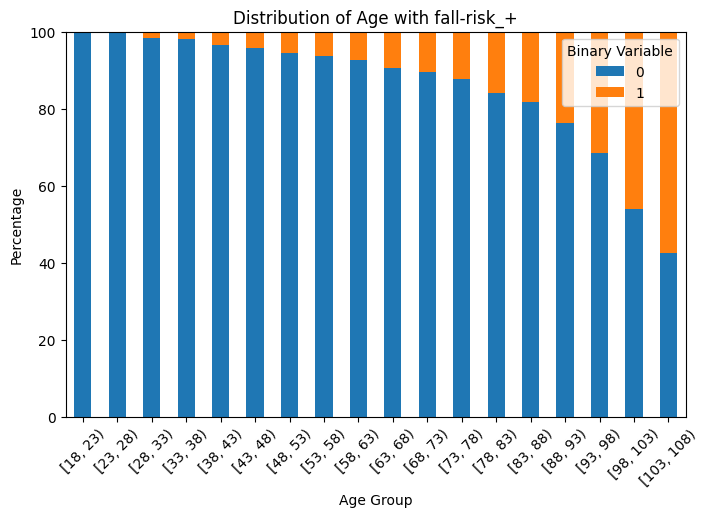

In [141]:
df_viz = df.copy()

# Define age bins
age_bins = range(18, 110, 5)  # 18-27, 28-37, ..., 78-84
df_viz['age_group'] = pd.cut(df_viz['age'], bins=age_bins, right=False)

# Count occurrences of 0 and 1 per age group
age_counts = df_viz.groupby('age_group')['fall-risk_+'].value_counts().unstack()

# Normalize to percentages
age_percent = age_counts.div(age_counts.sum(axis=1), axis=0) * 100

# Plot
fig, ax = plt.subplots(figsize=(8, 5))
age_percent.plot(kind='bar', stacked=True, color=['#1f77b4', '#ff7f0e'], ax=ax)

# Labels and customization
plt.xlabel("Age Group")
plt.ylabel("Percentage")
plt.title("Distribution of Age with fall-risk_+")
plt.legend(["0", "1"], title="Binary Variable")
plt.xticks(rotation=45)
plt.ylim(0, 100)

plt.show()

Age and fall_risk_+ are highly correlated. This is depicted better than by computing a correlation score (which can be tricky between cont. and bin varaibles). Therefore removing either of them does not have large effect on model performance.

What is weird though is that both of them have large SHAP values. 

C:\Users\felix\AppData\Local\Temp\ipykernel_22868\2492159077.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_counts = df_viz.groupby('age_group')['walk-balance_and_gait_impaired'].value_counts().unstack()


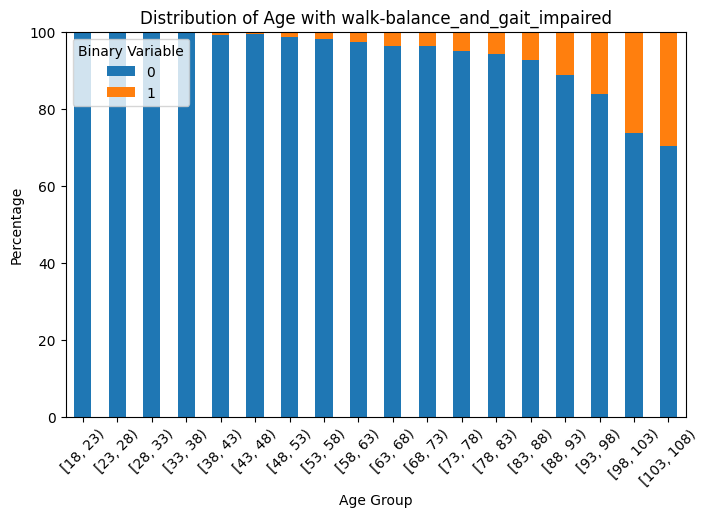

In [44]:
df_viz = df.copy()

# Define age bins
age_bins = range(18, 110, 5)  # 18-27, 28-37, ..., 78-84
df_viz['age_group'] = pd.cut(df_viz['age'], bins=age_bins, right=False)

# Count occurrences of 0 and 1 per age group
age_counts = df_viz.groupby('age_group')['walk-balance_and_gait_impaired'].value_counts().unstack()

# Normalize to percentages
age_percent = age_counts.div(age_counts.sum(axis=1), axis=0) * 100

# Plot
fig, ax = plt.subplots(figsize=(8, 5))
age_percent.plot(kind='bar', stacked=True, color=['#1f77b4', '#ff7f0e'], ax=ax)

# Labels and customization
plt.xlabel("Age Group")
plt.ylabel("Percentage")
plt.title("Distribution of Age with walk-balance_and_gait_impaired")
plt.legend(["0", "1"], title="Binary Variable")
plt.xticks(rotation=45)
plt.ylim(0, 100)

plt.show()

Same here, even though the effect is not as pronounced.

Text(0.5, 1.0, 'Interaction Between Two Binary Variables')

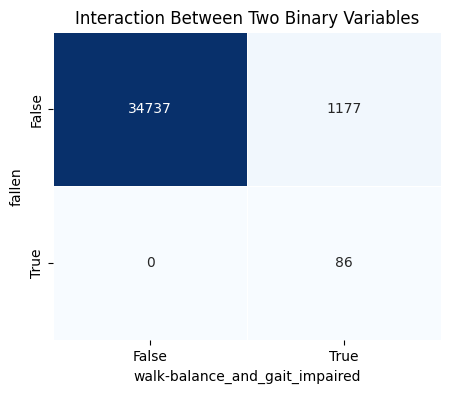

In [143]:
# Count occurrences of (binary_var_1, binary_var_2) pairs
heatmap_data = df_viz.groupby(['fallen', 'walk-balance_and_gait_impaired']).size().unstack(fill_value=0)

# Convert to integers explicitly (not always necessary, but avoids errors)
heatmap_data = heatmap_data.astype(int)

# Plot
plt.figure(figsize=(5, 4))
sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='Blues', linewidths=0.5, cbar=False)

# Labels
plt.xlabel("walk-balance_and_gait_impaired")
plt.ylabel("fallen")
plt.title("Interaction Between Two Binary Variables")


Text(0.5, 1.0, 'Interaction Between Two Binary Variables')

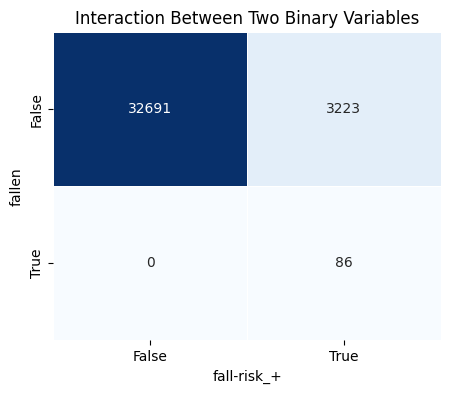

In [148]:
# Count occurrences of (binary_var_1, binary_var_2) pairs
heatmap_data = df_viz.groupby(['fallen', 'fall-risk_+']).size().unstack(fill_value=0)

# Convert to integers explicitly (not always necessary, but avoids errors)
heatmap_data = heatmap_data.astype(int)

# Plot
plt.figure(figsize=(5, 4))
sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='Blues', linewidths=0.5, cbar=False)

# Labels
plt.xlabel("fall-risk_+")
plt.ylabel("fallen")
plt.title("Interaction Between Two Binary Variables")


Text(0.5, 1.0, 'Interaction Between Two Binary Variables')

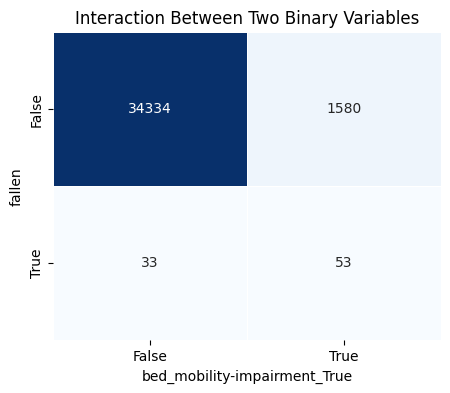

In [145]:
# Count occurrences of (binary_var_1, binary_var_2) pairs
heatmap_data = df_viz.groupby(['fallen', 'bed_mobility-impairment_True']).size().unstack(fill_value=0)

# Convert to integers explicitly (not always necessary, but avoids errors)
heatmap_data = heatmap_data.astype(int)

# Plot
plt.figure(figsize=(5, 4))
sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='Blues', linewidths=0.5, cbar=False)

# Labels
plt.xlabel("bed_mobility-impairment_True")
plt.ylabel("fallen")
plt.title("Interaction Between Two Binary Variables")


Text(0.5, 1.0, 'Interaction Between Two Binary Variables')

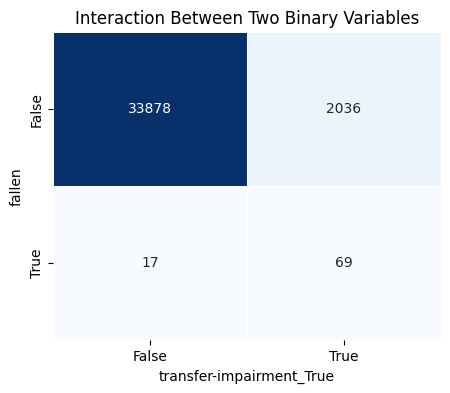

In [147]:
# Count occurrences of (binary_var_1, binary_var_2) pairs
heatmap_data = df_viz.groupby(['fallen', 'transfer-impairment_True']).size().unstack(fill_value=0)

# Convert to integers explicitly (not always necessary, but avoids errors)
heatmap_data = heatmap_data.astype(int)

# Plot
plt.figure(figsize=(5, 4))
sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='Blues', linewidths=0.5, cbar=False)

# Labels
plt.xlabel("transfer-impairment_True")
plt.ylabel("fallen")
plt.title("Interaction Between Two Binary Variables")


## CatBoost

In [ ]:

def cat_pipeline(df):
    """
    Trains and evaluates a Decision Tree model with hyperparameter tuning, 
    finds the best threshold for recall/precision, and visualizes performance.

    Args:
        df (pd.DataFrame): The cleaned dataset.
        target_col (str): Target variable name.
        test_size (float): Train-test split ratio.
        random_state (int): Random seed for reproducibility.

    Returns:
        dict: Model performance metrics.
    """


    X = df.drop(columns=["fallen", "id"])  # Features
    y = df["fallen"]  # Target  

    # Split train/test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Define categorical features
    all_features = set(X.columns)  # Convert to set for set operations
    non_cat_features = {"age", "fall-how_many_last_12_month"}  # Define explicitly
    cat_features = list(all_features.difference(non_cat_features))  # Ensure correct conversion

    train_pool = Pool(X_train, label=y_train, cat_features=cat_features)
    # Train a CatBoost model
    model = CatBoostClassifier(verbose=False)
    

    param_grid = {
        'iterations': [100, 200],
        'depth': [4, 6],
        'learning_rate': [0.01, 0.1]
    }

    # === Step 2: Hyperparameter Tuning using GridSearchCV ===
    grid_search = GridSearchCV(model, param_grid, scoring="recall", cv=5, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Best model after tuning
    best_classifier = grid_search.best_estimator_

    # # Print the best parameters and best score
    print("\nBest parameters found:")
    print(grid_search.best_params_)
    print(f"Best cross-validation recall: {grid_search.best_score_:.4f}")



    # # Train a model with the best parameters
    best_classifier.fit(X_train, y_train)

    # Evaluate on test set
    y_pred_best_classifier = best_classifier.predict(X_test)
    print(np.unique(y_pred_best_classifier, return_counts=True))

    print("\nTest set performance with optimized hyperparameters:")
    print(f"Recall: {recall_score(y_test, y_pred_best_classifier):.4f}")
    print(classification_report(y_test, y_pred_best_classifier))


    # # === Step 3: Cross-Validation Prediction for Evaluation ===
    cv = StratifiedKFold(n_splits=5)
    y_probs = cross_val_predict(best_classifier, X, y, cv=cv, method="predict_proba")[:, 1]

    

    # # === Step 4: Compute AUC-PR ===
    precision, recall, thresholds = precision_recall_curve(y, y_probs)
    auc_pr = auc(recall, precision)

    print(f"AUC-PR Score: {auc_pr:.4f}")

    # === Step 5: Plot Precision-Recall Curve ===
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, marker=".", label=f"AUC-PR = {auc_pr:.4f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend()
    plt.grid()
    plt.show()

    # === Step 6: Histogram of Prediction Probabilities ===
    plt.figure(figsize=(8, 6))
    plt.hist(y_probs, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
    plt.title("Histogram of Predicted Fall Probabilities")
    plt.xlabel("Predicted Probability of Fall (fallen=1)")
    plt.ylabel("Frequency")

    # Apply logarithmic scale to y-axis
    plt.yscale('log')
    plt.grid(True)
    plt.show()

    # === Step 7: Find Best Threshold for Recall-Precision Tradeoff ===
    best_threshold = thresholds[np.argmax(precision * recall)]
    print(f"Best Threshold for Precision-Recall Balance: {best_threshold:.4f}")

    # Apply the best threshold
    y_pred = (y_probs >= best_threshold).astype(int)

    # === Step 8: Confusion Matrix ===
    cm = confusion_matrix(y, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Fall", "Fall"], yticklabels=["Not Fall", "Fall"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

    # === Step 9: Feature Importance ===
    feature_importances = pd.DataFrame(
        {"Feature": X.columns, "Importance": best_classifier.feature_importances_}
    ).sort_values(by="Importance", ascending=False)

    print("Top 10 Important Features:")
    print(feature_importances.head(30))

     # # Compute SHAP values
    explainer = shap.TreeExplainer(best_classifier)
    shap_values = explainer(X_train)

    shap.plots.waterfall(shap_values[0])

    shap.plots.bar(shap_values)

    shap.plots.beeswarm(shap_values)

            

0:	learn: 0.4089763	total: 11.2ms	remaining: 2.22s
1:	learn: 0.2313755	total: 20.8ms	remaining: 2.06s
2:	learn: 0.1444843	total: 30.5ms	remaining: 2s
3:	learn: 0.0916096	total: 38.4ms	remaining: 1.88s
4:	learn: 0.0598378	total: 50ms	remaining: 1.95s
5:	learn: 0.0367882	total: 58.7ms	remaining: 1.9s
6:	learn: 0.0232288	total: 68.2ms	remaining: 1.88s
7:	learn: 0.0174709	total: 77.7ms	remaining: 1.86s
8:	learn: 0.0135072	total: 85.9ms	remaining: 1.82s
9:	learn: 0.0122065	total: 95.9ms	remaining: 1.82s
10:	learn: 0.0105512	total: 105ms	remaining: 1.8s
11:	learn: 0.0101726	total: 114ms	remaining: 1.79s
12:	learn: 0.0093904	total: 123ms	remaining: 1.77s
13:	learn: 0.0088859	total: 135ms	remaining: 1.8s
14:	learn: 0.0087867	total: 144ms	remaining: 1.77s
15:	learn: 0.0084374	total: 153ms	remaining: 1.75s
16:	learn: 0.0082184	total: 164ms	remaining: 1.77s
17:	learn: 0.0081348	total: 176ms	remaining: 1.77s
18:	learn: 0.0079548	total: 185ms	remaining: 1.77s
19:	learn: 0.0079193	total: 198ms	remai

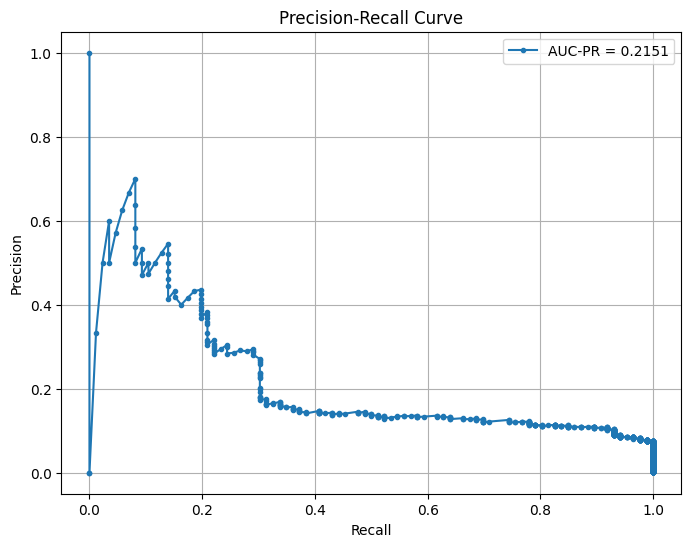

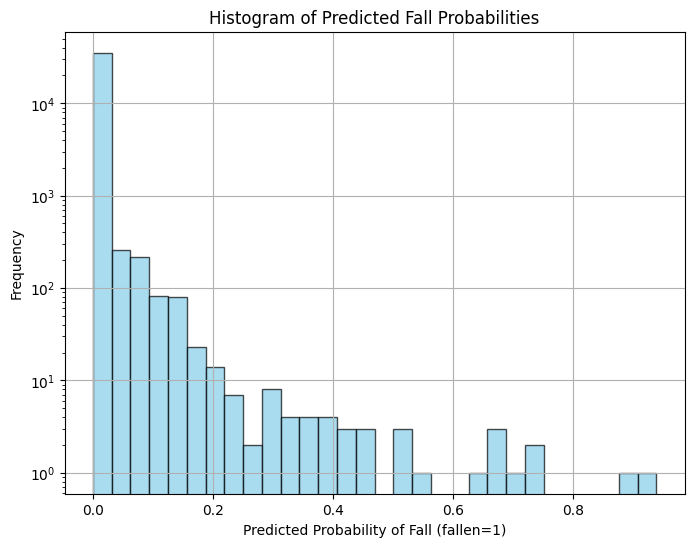

Best Threshold for Precision-Recall Balance: 0.0301


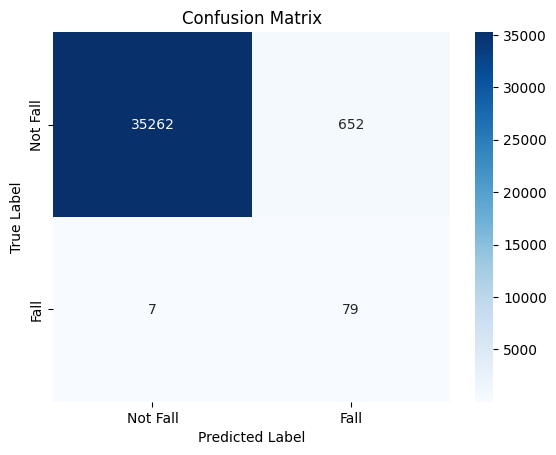

Top 10 Important Features:
                                Feature  Importance
4        walk-balance_and_gait_impaired   28.158670
0                                   age   25.844570
2                           fall-risk_+   12.187706
10             transfer-impairment_True    9.589404
11        bed_mobility-impairment_False    5.918973
1                           fall-risk_0    5.572471
12         bed_mobility-impairment_True    5.202699
9           transfer-impairment_Unknown    2.638099
6               excretions-incontinence    1.869898
5           fall-how_many_last_12_month    1.294566
7                  fall-while_stay_True    0.856030
13  fall-how_many_last_12_month_missing    0.440285
8               fall-while_stay_Unknown    0.422571
3                          fall-risk_++    0.004058


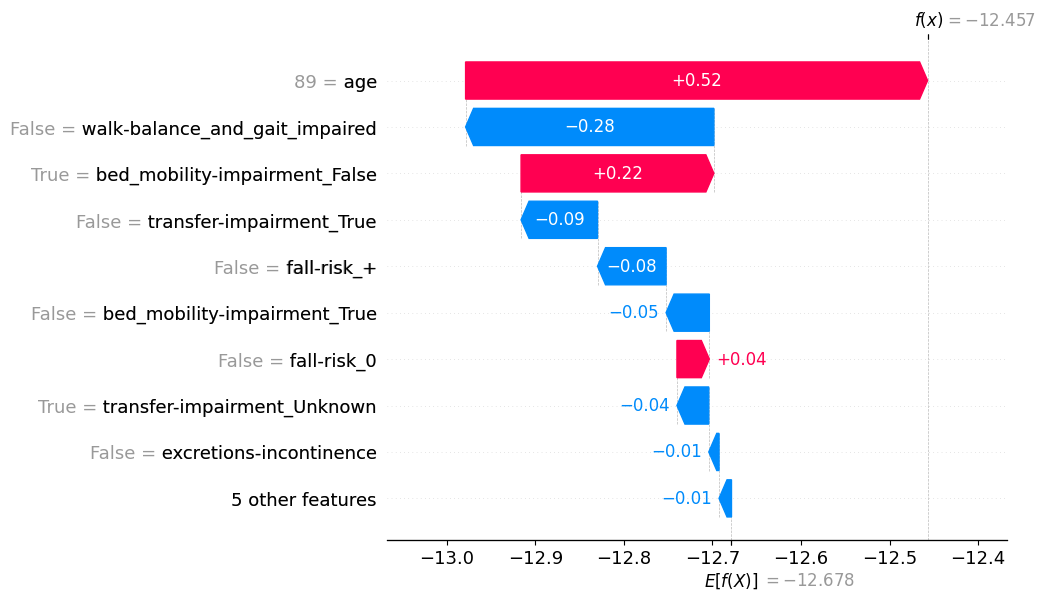

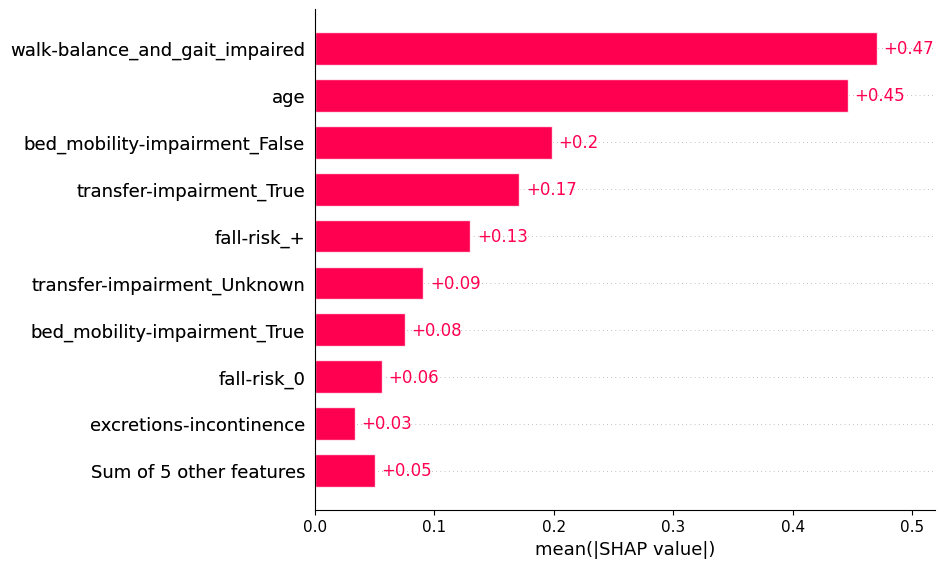

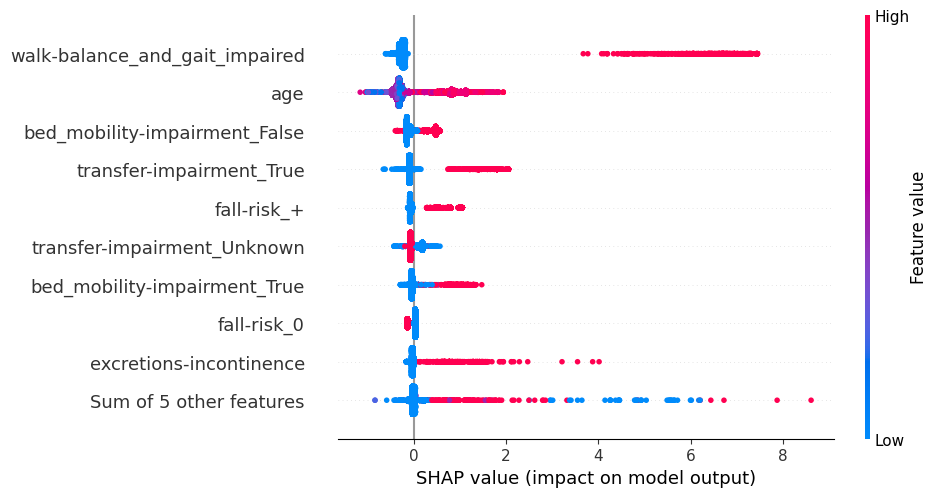

In [75]:
cat_pipeline(df1)

## Conclusion XGBoost works way faster than CatBoost and yields similar results in terms of SHAP-values and even better in AURC